<a href="https://colab.research.google.com/github/gupta-manya/malicious-url-detection-/blob/main/modek_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 download Dataset

In [ ]:
!pip install kagglehub numpy pandas scikit-learn matplotlib seaborn tldextract textblob python-whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 9.4 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

print("Path to dataset files:", path)

100%|██████████| 16.9M/16.9M [00:00<00:00, 95.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sid321axn/malicious-urls-dataset/versions/1


In [ ]:
import os
import numpy as np
import pandas as pd

df = pd.read_csv(os.path.join(path, "malicious_phish.csv"))
print(df.head())
print('=' * 150)
print(df.info())
print('=' * 150)
print(df['type'].value_counts())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


In [ ]:
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())
df.drop_duplicates(inplace=True)
df.dropna()
print('=' * 150)
print("after deleting dublicates and nulls:-")
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())

dublicates url =  10066
null urls =  url     0
type    0
dtype: int64
after deleting dublicates and nulls:-
dublicates url =  0
null urls =  url     0
type    0
dtype: int64


# Step **2** extracting features

#### Importing Libraries and files

In [ ]:
import re
import socket
from urllib.parse import urlparse
import whois
import datetime
import ssl
import tldextract

#### Feature extraction functions

In [ ]:
#extract_features.py

try:
    with open("top-1m.csv", "r") as f:
        top_domains = {line.strip().split(',')[1] for line in f}
except:
    top_domains = None
#lexical
def extract_lexical_features(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or ""
    ext = tldextract.extract(url)
    domain = f"{ext.domain}.{ext.suffix}"

    # suspicious tld - https://www.cybercrimeinfocenter.org/top-20-tlds-by-malicious-phishing-domains
    suspicious_tlds = {'zip', 'xyz', 'tk', 'top', 'gq', 'ga', 'ml', 'cyou', 'buzz', 'cf', 'icu', 'wang', 'live'}

    return {
        "url":url,
        "domain": domain,
        #len>75
        "url_length": len(url),
        #len>50
        "hostname_length": len(hostname),
        #num>1
        "num_dots": url.count('.'),
        #num>1
        "num_hyphens": url.count('-'),
        #http
        "has_https": int(url.startswith("https")),
        #num>4
        "num_subdirs": url.count('/'),
        #num>8
        "num_digits": sum(c.isdigit() for c in url),
        #num>4
        "num_params": url.count('='),
        #num>1
        "num_fragments": url.count('#'),
        #num>10
        "num_uppercase": sum(c.isupper() for c in url),
        #yes
        "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        #yes
        "has_port": int(':' in hostname),
        #yes
        "is_encoded": int('%' in url),
        #no
        "starts_with_www": int(hostname.startswith("www")),
        #yes
        "ends_with_suspicious_tld": int(ext.suffix in suspicious_tlds),

        #suspicious words - https://www.researchgate.net/figure/Suspicious-words-to-detect-phishing-URLs_fig6_364265241
        "suspicious_words": int(any(w in url.lower() for w in ['login', 'verify', 'account', 'update', 'secure', 'bank', 'lucky', 'bonus', 'gift', 'signin']))
    }
try:
    context = ssl.create_default_context()
except:
    context=None
#host based
def extract_host_features(domain):
    features = {
        #"domain_age_days": -1,
        "dns_record_exists": 0,
        "has_ssl_certificate": 0,
        "is_alexa_top": 0
    }
    # dom age
    '''
    try:
        try:
            w = whois.whois(domain)
            creation_date = w.creation_date
            if isinstance(creation_date, list):
                creation_date = creation_date[0]
            if creation_date:
                age = (datetime.datetime.now() - creation_date).days
                features["domain_age_days"] = age
        except:
            pass
    except:
        pass
    '''
    # DNS Check
    try:
        socket.gethostbyname(domain)
        features["dns_record_exists"] = 1
    except:
        pass
    # ssl check
    try:
        if context:
            with socket.create_connection((domain, 443), timeout=3) as sock:
                with context.wrap_socket(sock, server_hostname=domain) as ssock:
                    features["has_ssl_certificate"] = 1
    except:
        pass
    # alexa top
    if top_domains:
        features["is_alexa_top"] = int(domain in top_domains)
    return features

#main func
def extract_all_features(url):
    lexical_features = extract_lexical_features(url)
    host_features = extract_host_features(lexical_features["domain"])
    return {**lexical_features, **host_features}


#### Extracting lexical features

In [ ]:
import pandas as pd
from tqdm import tqdm

# Sample 10% from each class in the 'label' column
sample_ratio = 1
sample_df = df.groupby('type', group_keys=False).apply(lambda x: x.sample(frac=sample_ratio, random_state=42))
tqdm.pandas()  # adds a progress bar to apply

# Apply feature extraction
lexical_features_df = sample_df['url'].progress_apply(lambda url: pd.Series(extract_lexical_features(url)))
lexical_features_df.head()
unique_domains = lexical_features_df["domain"].unique()
#extract_features_df = unique_domain['domain'].progress_apply(lambda domain: pd.Series(extract_host_features(domain)))
# Concatenate with original DataFrame (optional)
df_with_features = pd.merge(sample_df, lexical_features_df, on='url')
df_with_features.head()

/tmp/ipython-input-12-3047814602.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('type', group_keys=False).apply(lambda x: x.sample(frac=sample_ratio, random_state=42))
100%|██████████| 641125/641125 [03:03<00:00, 3498.21it/s]


,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,num_fragments,num_uppercase,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,1,0,0,0,0,0,0,0,0
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0
3,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,0,0,0,0,0,0,0,0,0
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0


#### Extracting Host features

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

results = {}
with ThreadPoolExecutor(max_workers=1000) as executor:
    futures = {executor.submit(extract_host_features, d): d for d in unique_domains}

    for future in tqdm(as_completed(futures), total=len(futures)):
        domain = futures[future]
        try :
            results[domain] = future.result()
        except:
            results[domain] = None

# To convert to DataFrame:
host_features_df = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={"index": "domain"})
host_features_df.head()






100%|██████████| 155574/155574 [02:27<00:00, 1054.86it/s]


,domain,dns_record_exists,has_ssl_certificate,is_alexa_top
0,panelphysicians.com,1,1,0
1,kjrh.com,1,1,0
2,villedesorel.tel,0,0,0
3,dobermantalk.com,1,1,0
4,newsmax.com,1,1,0


In [ ]:
for column in host_features_df.columns:
    if column != "domain":
        print(column, host_features_df[column].value_counts())

dns_record_exists dns_record_exists
1    98486
0    57088
Name: count, dtype: int64
has_ssl_certificate has_ssl_certificate
0    80343
1    75231
Name: count, dtype: int64
is_alexa_top is_alexa_top
0    155574
Name: count, dtype: int64


In [ ]:

df_with_features = pd.merge(df_with_features, host_features_df, on='domain')
df_with_features["label"] = df_with_features["type"].apply(lambda t:1 if t == 'benign' else 0)

df_with_features.head()



,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,...,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,dns_record_exists,has_ssl_certificate,is_alexa_top,label
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,...,0,0,0,0,0,0,1,1,0,1
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,...,0,0,0,0,0,0,1,1,0,1
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,...,0,0,0,0,0,0,1,1,0,1
3,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,...,0,0,0,0,0,0,1,0,0,1
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1


In [ ]:
df_with_features.to_csv('extracted_data_set.csv', index=False)

### removing less correlated columns

In [ ]:
#domain_data = pd.read_csv("extracted_data_set_for_domain_ageV1.csv")
import pandas as pd
extracted_dataset = pd.read_csv("extracted_data_set.csv")
extracted_dataset.head()

,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,...,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,dns_record_exists,has_ssl_certificate,is_alexa_top,label
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,...,0,0,0,0,0,0,1,1,0,1
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,...,0,0,0,0,0,0,1,1,0,1
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,...,0,0,0,0,0,0,1,1,0,1
3,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,...,0,0,0,0,0,0,1,0,0,1
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1


In [ ]:
light_df = extracted_dataset[['url_length', 'hostname_length', 'num_dots',
       'num_hyphens', 'has_https', 'num_subdirs', 'num_digits', 'num_params',
       'num_fragments', 'num_uppercase', 'has_ip', 'has_port', 'is_encoded',
       'starts_with_www', 'ends_with_suspicious_tld', 'suspicious_words',
       'dns_record_exists', 'has_ssl_certificate', 'is_alexa_top', 'label',
       ]]
light_df.describe()

,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,num_fragments,num_uppercase,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,dns_record_exists,has_ssl_certificate,is_alexa_top,label
count,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.0,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.000000,641137.0,641137.000000
mean,59.761756,4.841201,2.193949,1.561339,0.024496,2.921881,5.371673,0.591626,0.000884,2.228981,0.019629,0.0,0.036328,0.114757,0.004643,0.053987,0.777341,0.648451,0.0,0.667698
std,44.894173,8.827841,1.491430,2.984712,0.154582,1.895762,11.630103,1.491288,0.032579,8.642069,0.138722,0.0,0.187104,0.318729,0.067984,0.225992,0.416032,0.477454,0.0,0.471039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,32.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000
50%,47.000000,0.000000,2.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000
75%,76.000000,10.000000,3.000000,2.000000,0.000000,4.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,1.000000
max,2175.000000,236.000000,42.000000,87.000000,1.000000,41.000000,1204.000000,51.000000,6.000000,649.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


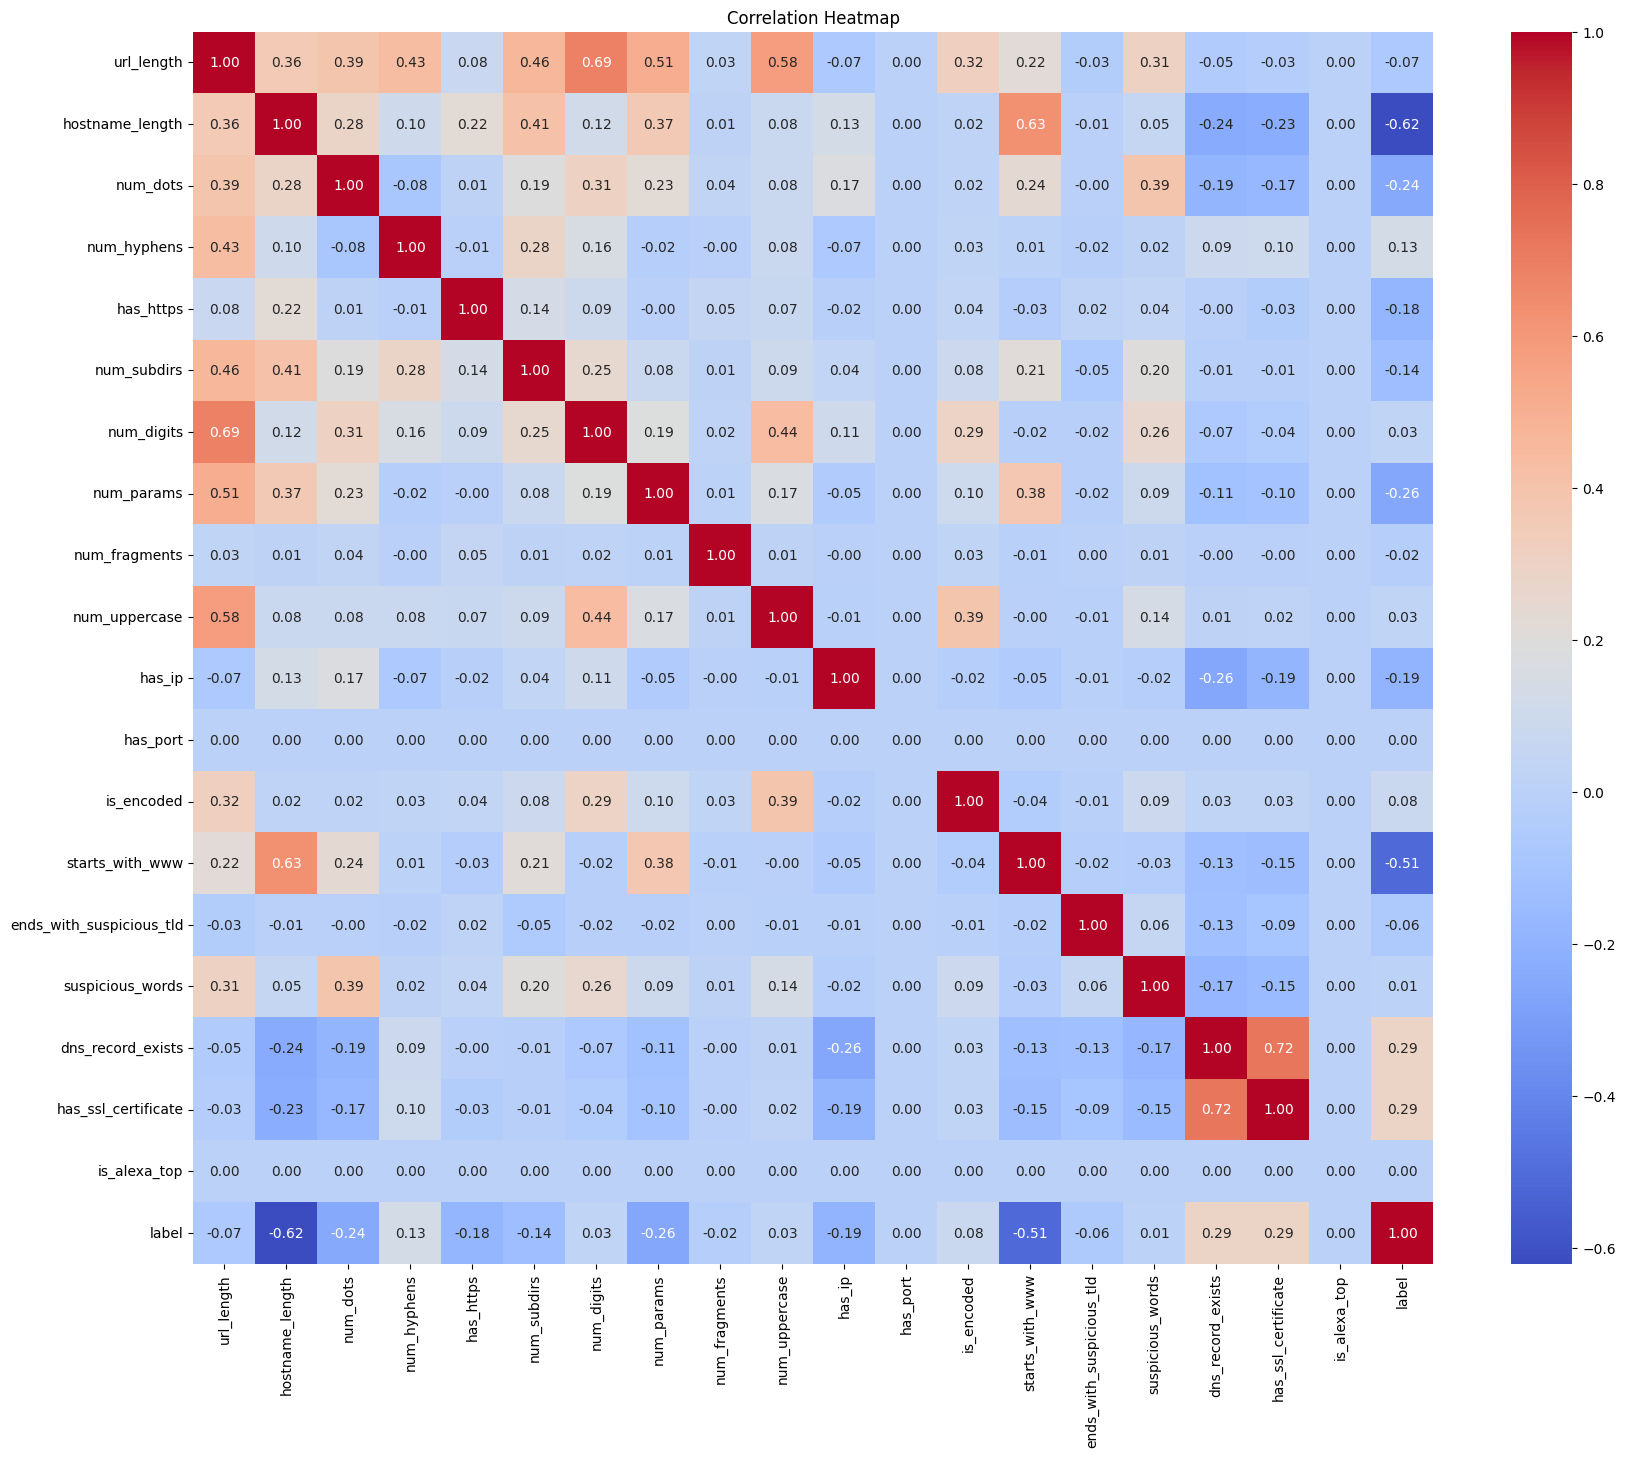

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = light_df.corr()
correlation.fillna(0,inplace=True)
f=open("final_corr.csv",'w')
f.write(correlation.to_csv())
f.close()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
drop_list = []
print("droping following row du to less value")
for i in correlation.index:
    if (0.05 > correlation["label"][i] > -0.05):
        print(i, correlation["label"][i])
        drop_list.append(i)
light_df.drop(drop_list,axis=1,inplace=True)
print('new columns:-\n',light_df.columns)

droping following row du to less value
num_digits 0.02878041410043343
num_fragments -0.023334460247258926
num_uppercase 0.028558344013460458
has_port 0.0
suspicious_words 0.012380488600068938
is_alexa_top 0.0
new columns:-
 Index(['url_length', 'hostname_length', 'num_dots', 'num_hyphens', 'has_https',
       'num_subdirs', 'num_params', 'has_ip', 'is_encoded', 'starts_with_www',
       'ends_with_suspicious_tld', 'dns_record_exists', 'has_ssl_certificate',
       'label'],
      dtype='object')


/tmp/ipython-input-23-390086464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light_df.drop(drop_list,axis=1,inplace=True)


In [ ]:
light_df.to_csv("kagels_training_set.csv",index=False)

# **Step 3 Traning and Evaluation of model**

### Training

#### Importing Libraries and files

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kagels_training_set.csv to kagels_training_set (1).csv


#### Select Independent and Dependent Features

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df = pd.read_csv("extracted_data_setV1.csv")
df.head()

In [ ]:
independent_features = ["url_length", "hostname_length", "num_dots", "num_hyphens", "has_https", "num_subdirs", "num_params", "has_ip", "is_encoded", "starts_with_www", "ends_with_suspicious_tld", "dns_record_exists", "is_alexa_top"]
dependent_features = ["label"]
print(df.shape)
X_train, X_test, y_train, y_test = train_test_split(
    df[independent_features], df[dependent_features], test_size=0.2, random_state=42
)

In [ ]:
#Print Dataset Shape and Split into Training and Testing Sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### Train the Random Forest Classifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.values.ravel())
y_test_encoded = le.transform(y_test.values.ravel())

In [ ]:
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
# Evaluate the Model Accuracy on Test Set
RFmodel.score(X_test,y_test)

0.9453395514240259

In [ ]:
# Save the Trained Model using Pickle
with open(fr"random_forest_model.pkl", "wb") as f:
  pickle.dump(RFmodel, f)

### Evaluation

In [ ]:
# Import Required Libraries
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


In [ ]:
# Load model from pkl file
with open(fr"random_forest_model.pkl", "rb") as f:
  RFmodel = pickle.load(f)

In [ ]:
y_pred = RFmodel.predict(X_test)

#### Confusion Matrix Display

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')

In [ ]:
#  precision recall f1-score Report
report = classification_report(y_test, y_pred)
print(report)

#### Feature Importance Plot

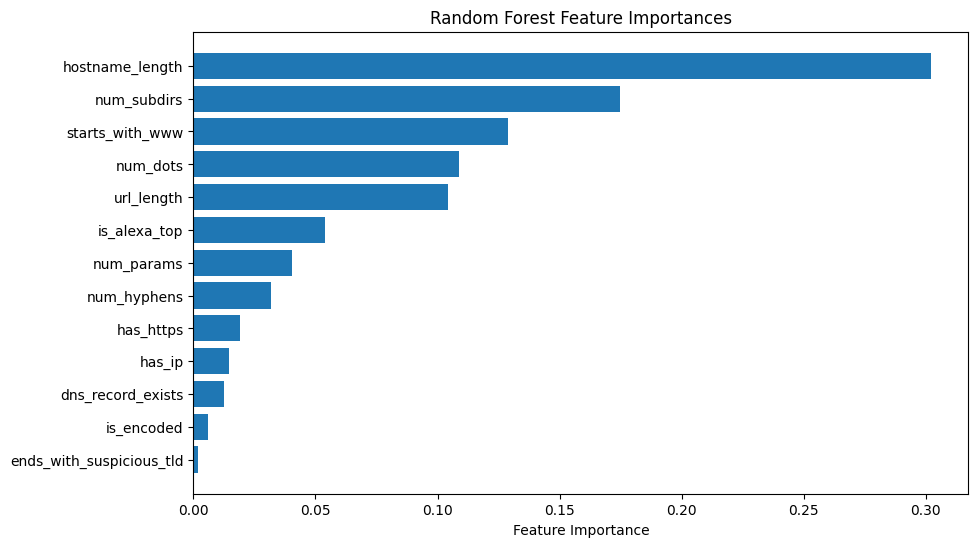

In [ ]:
importances = RFmodel.feature_importances_
features = X_test.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


#### User input prediction

In [ ]:
def user_input_prediction(user_url):
  independent_features = ["url_length", "hostname_length", "num_dots", "num_hyphens", "has_https", "num_subdirs", "num_params", "has_ip", "is_encoded", "starts_with_www", "ends_with_suspicious_tld", "dns_record_exists", "is_alexa_top"]
  features_dict = extract_all_features(user_url)
  print(pd.DataFrame([features_dict])[independent_features].to_string(index=False))
  prediction = RFmodel.predict(pd.DataFrame([features_dict])[independent_features])
  return "safe" if prediction[0] else "malicious: "

In [ ]:
user_url = input("Enter a URL to check if it's safe or malicious: ").strip()
predicted_class = user_input_prediction(user_url)
print(f" The entered {user_url} is classified as: **{predicted_class.upper()}**")

Enter a URL to check if it's safe or malicious: http://secure-login-update.ga/login
 url_length  hostname_length  num_dots  num_hyphens  has_https  num_subdirs  num_params  has_ip  is_encoded  starts_with_www  ends_with_suspicious_tld  dns_record_exists  is_alexa_top
         35               22         1            2          0            3           0       0           0                0                         1                  0             0
 The entered http://secure-login-update.ga/login is classified as: **MALICIOUS: **
